In [ ]:
import os
from pydantic import BaseModel
from typing import List
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph,START,END


In [4]:
from langchain_community.document_loaders import TextLoader


In [5]:
docs=TextLoader("research_notes.txt",encoding="utf-8").load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
chunk=splitter.split_documents(docs)


In [6]:
embeddings=HuggingFaceEmbeddings()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 286.69it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [7]:
vectorstore=FAISS.from_documents(chunk,embedding=embeddings)
retriever=vectorstore.as_retriever()

In [8]:
import os
from langchain_groq.chat_models import ChatGroq
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")
from dotenv import load_dotenv
load_dotenv()
llm=ChatGroq(model='openai/gpt-oss-120b')

In [9]:
llm.invoke("Hi").content

'Hello! How can I assist you today?'

In [11]:
#Ragrefelction 
class RAGreflectionState(BaseModel):
    question:str
    retrieved_docs:List[Document]=[]
    answer:str=""
    reflection:str="False"
    attempts:int=0

In [13]:
#Nodes
def retrieve_docs(state:RAGreflectionState)->RAGreflectionState:
    docs=retriever.invoke(state.question )
    return state.model_copy(update={"retrieved_docs":docs})

def generate_answer(state:RAGreflectionState)->RAGreflectionState:
    context="\n\n".join([doc.page_content for doc in state.retrieve_docs])
    prompt=f"""
    Use the following context to answer the question:
    {context}

    question:{state.question}

    """
    answer=model.invoke(prompt)
    return state.model_copy(update={"answer":answer})

#Retriever



In [17]:

#Self reflection
def reflect_on_answer(state:RAGreflectionState)->RAGreflectionState:
    prompt=f"""
    Reflect on the follwing answer to see if it fully addresses the question.
    State YES if it is complete ans correct or NO with an explaination
    Question:{state.question}
    Answer:{state.answer}
    """

def finalize(state:RAGreflectionState)->RAGreflectionState:
    """tHIS STEP IS THE STEP THAT IS USED  FOR FINALIsing"""
    return "end of the processes"

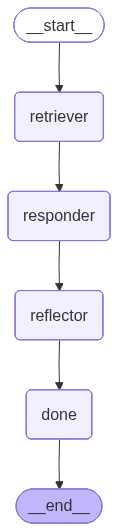

In [20]:
builder=StateGraph(RAGreflectionState)
builder.add_node("retriever",retrieve_docs)
builder.add_node("responder",generate_answer)
builder.add_node("reflector",reflect_on_answer)
builder.add_node("done",finalize)

builder.set_entry_point("retriever")
builder.add_edge("retriever","responder")
builder.add_edge("responder","reflector")
builder.add_edge("reflector","done")

graph=builder.compile()
graph 

